# DenseNet Replications

## Contents:<a class="anchor" id="contents"></a>
* [Setup, Data preparation and Callbacks](#setup)
* [CIFAR CNN Replications](#cifar)
* [PCam G-CNN Replications](#pcam)

## Setup, Data preparation and Callbacks <a class="anchor" id="setup"></a>
----------------------------------

In [2]:
%load_ext jupyternotify
import time
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from keras import models, layers, optimizers, regularizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras import Input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras
import os, shutil
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras_gcnn.layers import GConv2D, GBatchNorm
from keras_gcnn.layers.pooling import GroupPool

#Loading my custom functions from a separate Jupyter notebook
from ipynb.fs.full.my_functions import build_and_compile_model, build_and_compile_model_GCNN, fit_model_to_generator, plot_auc, area_under_ROC_curve
from ipynb.fs.full.my_functions import plot_results,plot_graphs, plot_smooth, plot_smooth_graphs, fit_model_to_directory_generator, evaluate_auc
from ipynb.fs.full.my_functions import build_and_compile_dense_model, crop, memory_required, count_conv_layers
from ipynb.fs.full.my_functions import model_ensemble_evaluation, acc_comparison, save_history, load_history

<IPython.core.display.Javascript object>

Using TensorFlow backend.


### Setting up custom Keras callbacks, mimicing the training setup of the academic papers.

In [3]:
class TimeSpent(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times = []
    def on_epoch_begin(self, epoch,logs={}):
        self.time_started = time.time()
    def on_epoch_end(self, epoch,logs={}):
        self.epoch_times.append(time.time()-self.time_started)
        
class LR_modifier(keras.callbacks.Callback):
    def __init__(self,
                 monitor='val_loss',
                 patience=0,
                 verbose=0):
        super(LR_modifier, self).__init__()

        self.monitor = monitor
        self.monitor_op = np.less
        self.patience = patience
        self.verbose = verbose
        self.wait = 0

    def on_train_begin(self, logs=None):
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                curr_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = curr_lr/2.
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait=0
                if(self.verbose==1):
                    print("Learn rate updated from {} to: {}".format(curr_lr,new_lr))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
        return monitor_value

    

time_check = TimeSpent()
lr_mod = LR_modifier(monitor="val_loss",patience=20,verbose=1)


totalepochs = 300
def sched(epoch,lr):
    if epoch == totalepochs*0.5 or epoch == totalepochs*0.75:
        return lr/10
    return lr

callbacks = [time_check,
            keras.callbacks.LearningRateScheduler(sched, verbose=1),
            keras.callbacks.ModelCheckpoint(
                filepath="model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
#             keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100)
            ]

#### Rotational paper callbacks

In [4]:
callbacks = [time_check,
            keras.callbacks.ModelCheckpoint(
                filepath="model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
             lr_mod
            ]

### Data preparation and generator setup

#### CIFAR

In [5]:
# from keras.datasets import cifar10
# from keras import utils

# (trainX, trainY), (testX, testY) = cifar10.load_data()
# trainX = trainX.astype('float32')
# testX = testX.astype('float32')

# trainX /= 255.
# testX /= 255.

# Y_train = utils.to_categorical(trainY, 10)
# Y_test = utils.to_categorical(testY, 10)

# generator = ImageDataGenerator()
# generator.fit(trainX, seed=0)

#### PCam

In [6]:
base_dir = "C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/converted_images/"
tr_dir = os.path.join(base_dir, "train")
va_dir = os.path.join(base_dir, "valid")
te_dir = os.path.join(base_dir, "test")

train_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64 
targ_size = (96,96)
classification = "binary"


validation_generator = train_datagen.flow_from_directory(
    va_dir,
    target_size=targ_size,
    batch_size=batch_size,
    class_mode=classification)

test_generator = train_datagen.flow_from_directory(
    te_dir,
    target_size=targ_size,
    batch_size=batch_size,
    class_mode=classification)


Found 32768 images belonging to 2 classes.
Found 32768 images belonging to 2 classes.


## CIFAR CNN Replications <a class="anchor" id="cifar"></a>
----------------------------------

### DenseNet40

In [7]:
initial_filters = 16

weight_decay = 1e-4 # Setting from the DenseNet paper

DenseNet40 = build_and_compile_dense_model(initial_filters,growth_rate=12,dense_blocks=3,conv_layers=12,
                                           is_gconv=False,padding="same",dropout=0.2,img_size=32,
                                           opt="DenseSGD",weight_decay=weight_decay,output="softmax",labels=10)

In [8]:
DenseNet40.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
%%notify

totalepochs = 90

historyDenseNet40 = DenseNet40.fit_generator(generator.flow(trainX, Y_train, batch_size=64), steps_per_epoch=len(trainX) // 64,
                    epochs=totalepochs,
                    callbacks=callbacks,
                    validation_data=(testX, Y_test),
                    verbose=1)
timeDenseNet40 = np.sum(time_check.epoch_times)
DenseNet40.save_weights("model_saves/CIFAR/DenseNet40Final.h5")

Epoch 1/90

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 109s 139ms/step - loss: 1.5361 - acc: 0.4859 - val_loss: 1.6657 - val_acc: 0.5094
Epoch 2/90

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 101s 130ms/step - loss: 1.0746 - acc: 0.6654 - val_loss: 1.5706 - val_acc: 0.5826
Epoch 3/90

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 103s 132ms/step - loss: 0.9228 - acc: 0.7254 - val_loss: 1.1192 - val_acc: 0.6777
Epoch 4/90

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 103s 132ms/step - loss: 0.8267 - acc: 0.7632 - val_loss: 1.1874 - val_acc: 0.6448
Epoch 5/90

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==========================

781/781 [==============================] - 101s 129ms/step - loss: 0.1402 - acc: 0.9945 - val_loss: 0.4843 - val_acc: 0.9057
Epoch 76/90

Epoch 00076: LearningRateScheduler setting learning rate to 0.009999999776482582.
781/781 [==============================] - 101s 129ms/step - loss: 0.1352 - acc: 0.9954 - val_loss: 0.4808 - val_acc: 0.9070
Epoch 77/90

Epoch 00077: LearningRateScheduler setting learning rate to 0.009999999776482582.
781/781 [==============================] - 99s 127ms/step - loss: 0.1324 - acc: 0.9951 - val_loss: 0.5062 - val_acc: 0.9056
Epoch 78/90

Epoch 00078: LearningRateScheduler setting learning rate to 0.009999999776482582.
781/781 [==============================] - 100s 128ms/step - loss: 0.1310 - acc: 0.9947 - val_loss: 0.5344 - val_acc: 0.8984
Epoch 79/90

Epoch 00079: LearningRateScheduler setting learning rate to 0.009999999776482582.
781/781 [==============================] - 100s 128ms/step - loss: 0.1270 - acc: 0.9954 - val_loss: 0.4724 - val_acc: 0.9

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

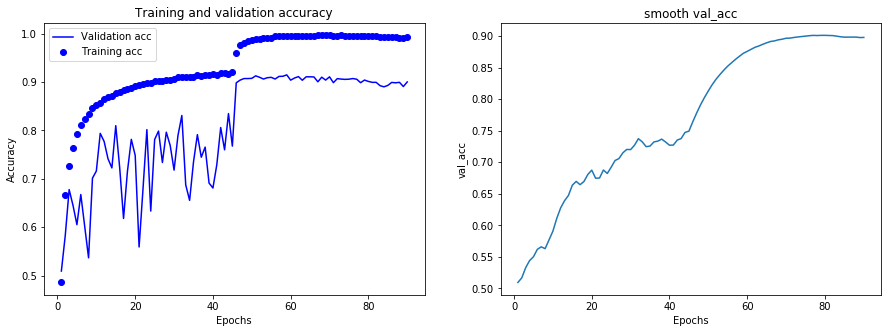

Highest val accuracy: x= 58, y= 0.9146


<Figure size 432x288 with 0 Axes>

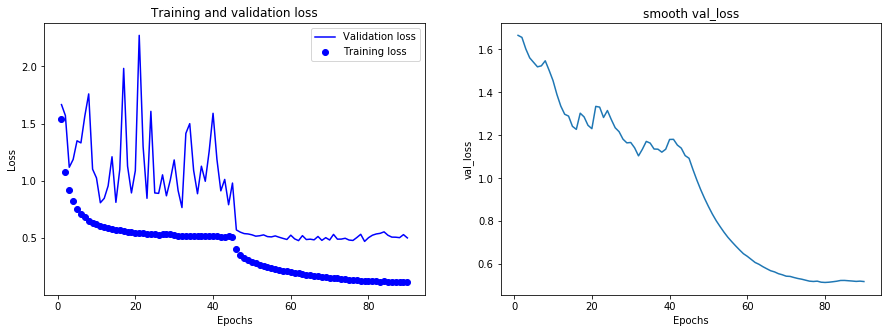

Lowest val loss: x= 78, y= 0.47241597232818605
9069.148169517517


In [10]:
plot_graphs(historyDenseNet40)
print(timeDenseNet40)

In [20]:
DenseNet40.evaluate(testX,Y_test)

10000/10000 [==============================] - 6s 603us/step


[0.5179865280628204, 0.9126]

### DenseNet-BC100

In [28]:
initial_filters = 24
weight_decay = 1e-4 # Setting from the DenseNet paper
DenseNet_BC100 = build_and_compile_dense_model(initial_filters,growth_rate=12,dense_blocks=3,conv_layers=16,
                                           is_gconv=False,padding="same",dropout=0.2,img_size=32,
                                           opt="DenseSGD",weight_decay=weight_decay,output="softmax",labels=10,bc_model=True)

In [16]:
DenseNet_BC100.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 32, 32, 24)   672         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 32, 32, 24)   96          conv2d_100[0][0]                 
__________________________________________________________________________________________________
activation_100 (Activation)     (None, 32, 32, 24)   0           batch_normalization_100[0][0]    
__________________________________________________________________________________________________
conv2d_101

In [17]:
%%notify

totalepochs=140

historyDenseNet_BC100 = DenseNet_BC100.fit_generator(generator.flow(trainX, Y_train, batch_size=64), steps_per_epoch=len(trainX) // 64,
                    epochs=totalepochs,
                    callbacks=callbacks,
                    validation_data=(testX, Y_test),
                    verbose=1)
timeDenseNet_BC100 = np.sum(time_check.epoch_times)
DenseNet_BC100.save_weights("model_saves/CIFAR/DenseNet_BC100Final.h5")

Epoch 1/140

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 205s 263ms/step - loss: 1.8249 - acc: 0.4985 - val_loss: 2.0026 - val_acc: 0.5261
Epoch 2/140

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 184s 235ms/step - loss: 1.2400 - acc: 0.6966 - val_loss: 2.6082 - val_acc: 0.4053
Epoch 3/140

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 184s 235ms/step - loss: 1.0122 - acc: 0.7647 - val_loss: 2.9741 - val_acc: 0.3662
Epoch 4/140

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 184s 235ms/step - loss: 0.8883 - acc: 0.7987 - val_loss: 1.1948 - val_acc: 0.7068
Epoch 5/140

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [=====================

781/781 [==============================] - 181s 232ms/step - loss: 0.5520 - acc: 0.9176 - val_loss: 1.0973 - val_acc: 0.7782
Epoch 39/140

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 181s 232ms/step - loss: 0.5437 - acc: 0.9197 - val_loss: 0.9555 - val_acc: 0.8053
Epoch 40/140

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 181s 232ms/step - loss: 0.5539 - acc: 0.9177 - val_loss: 0.8460 - val_acc: 0.8458
Epoch 41/140

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 181s 232ms/step - loss: 0.5462 - acc: 0.9198 - val_loss: 1.0423 - val_acc: 0.7980
Epoch 42/140

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
781/781 [==============================] - 181s 232ms/step - loss: 0.5416 - acc: 0.9217 - val_loss: 0.8948 - val_acc: 0.

781/781 [==============================] - 178s 228ms/step - loss: 0.1184 - acc: 0.9993 - val_loss: 0.4072 - val_acc: 0.9316
Epoch 113/140

Epoch 00113: LearningRateScheduler setting learning rate to 0.0009999999310821295.
781/781 [==============================] - 178s 228ms/step - loss: 0.1181 - acc: 0.9993 - val_loss: 0.4051 - val_acc: 0.9321
Epoch 114/140

Epoch 00114: LearningRateScheduler setting learning rate to 0.0009999999310821295.
781/781 [==============================] - 178s 229ms/step - loss: 0.1173 - acc: 0.9995 - val_loss: 0.4043 - val_acc: 0.9317
Epoch 115/140

Epoch 00115: LearningRateScheduler setting learning rate to 0.0009999999310821295.
781/781 [==============================] - 178s 228ms/step - loss: 0.1168 - acc: 0.9995 - val_loss: 0.4053 - val_acc: 0.9317
Epoch 116/140

Epoch 00116: LearningRateScheduler setting learning rate to 0.0009999999310821295.
781/781 [==============================] - 178s 228ms/step - loss: 0.1167 - acc: 0.9995 - val_loss: 0.4043 -

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

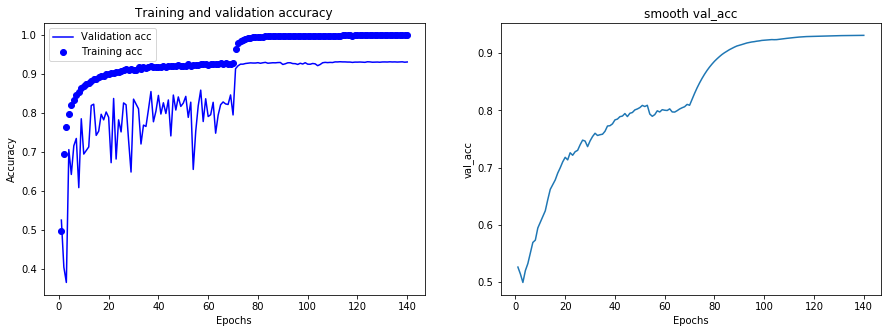

Highest val accuracy: x= 112, y= 0.9321


<Figure size 432x288 with 0 Axes>

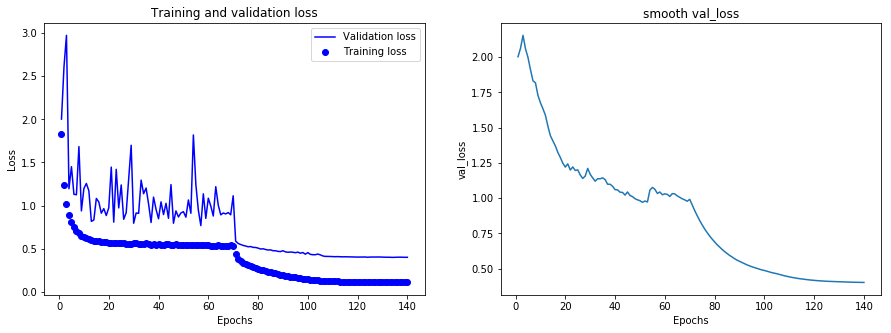

Lowest val loss: x= 133, y= 0.3980692958831787
25154.38741016388


In [18]:
plot_graphs(historyDenseNet_BC100)
print(timeDenseNet_BC100)

In [20]:
DenseNet_BC100.evaluate(testX,Y_test)

10000/10000 [==============================] - 11s 1ms/step


[0.39930407047271727, 0.9315]

## PatchCamelyon G-CNN Replications <a class="anchor" id="pcam"></a>
----------------------------------

### P4-48

In [48]:
initial_filters = 16
weight_decay = 1e-4 # Setting from the DenseNet paper
P4_DenseNet_48 = build_and_compile_dense_model(initial_filters,growth_rate=12,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="C4",padding="valid",dropout=0.2,img_size=96,
                                           opt="Adam",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [13]:
P4_DenseNet_48.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_11 (GConv2D)           (None, 94, 94, 64)   432         input_2[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_11 (GBatchNorm)    (None, 94, 94, 64)   64          g_conv2d_11[0][0]                
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 94, 94, 64)   0           g_batch_norm_11[0][0]            
__________________________________________________________________________________________________
g_conv2d_1

In [14]:
%%notify

totalepochs=400

historyP4_DenseNet_48 = fit_model_to_directory_generator(P4_DenseNet_48,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4_DenseNet_48 = np.sum(time_check.epoch_times)
P4_DenseNet_48.save_weights("model_saves/PCAM/PCAM_Dense/replication_attempts/P4_DenseNet_48Final.h5")
save_history(historyP4_DenseNet_48,"historyP4_DenseNet_48")

Found 262144 images belonging to 2 classes.
Epoch 1/400
312/312 [==============================] - 68s 217ms/step - loss: 0.4921 - acc: 0.7944 - val_loss: 0.9316 - val_acc: 0.6191
Epoch 2/400
312/312 [==============================] - 64s 206ms/step - loss: 0.4525 - acc: 0.8179 - val_loss: 0.4972 - val_acc: 0.7635
Epoch 3/400
312/312 [==============================] - 64s 207ms/step - loss: 0.4382 - acc: 0.8238 - val_loss: 0.6778 - val_acc: 0.6782
Epoch 4/400
312/312 [==============================] - 64s 206ms/step - loss: 0.4214 - acc: 0.8312 - val_loss: 0.9365 - val_acc: 0.5718
Epoch 5/400
312/312 [==============================] - 64s 206ms/step - loss: 0.4155 - acc: 0.8315 - val_loss: 0.7538 - val_acc: 0.6486
Epoch 6/400
312/312 [==============================] - 64s 206ms/step - loss: 0.4180 - acc: 0.8260 - val_loss: 0.9850 - val_acc: 0.5927
Epoch 7/400
312/312 [==============================] - 65s 207ms/step - loss: 0.4024 - acc: 0.8369 - val_loss: 0.7202 - val_acc: 0.6477
Epoc

Learn rate updated from 0.0002500000118743628 to: 0.0001250000059371814
Epoch 119/400
312/312 [==============================] - 68s 219ms/step - loss: 0.1494 - acc: 0.9562 - val_loss: 0.3703 - val_acc: 0.8793
Epoch 120/400
312/312 [==============================] - 67s 215ms/step - loss: 0.1477 - acc: 0.9562 - val_loss: 0.4260 - val_acc: 0.8603
Epoch 121/400
312/312 [==============================] - 66s 211ms/step - loss: 0.1423 - acc: 0.9602 - val_loss: 0.4631 - val_acc: 0.8398
Epoch 122/400
312/312 [==============================] - 67s 216ms/step - loss: 0.1494 - acc: 0.9551 - val_loss: 0.5935 - val_acc: 0.7890
Epoch 123/400
312/312 [==============================] - 69s 221ms/step - loss: 0.1407 - acc: 0.9585 - val_loss: 0.3601 - val_acc: 0.8853
Epoch 124/400
312/312 [==============================] - 67s 215ms/step - loss: 0.1513 - acc: 0.9537 - val_loss: 0.3126 - val_acc: 0.8871
Epoch 125/400
312/312 [==============================] - 68s 218ms/step - loss: 0.1442 - acc: 0.9567

Epoch 177/400
312/312 [==============================] - 67s 216ms/step - loss: 0.1281 - acc: 0.9620 - val_loss: 0.3825 - val_acc: 0.8707
Epoch 178/400
312/312 [==============================] - 68s 217ms/step - loss: 0.1323 - acc: 0.9614 - val_loss: 0.4692 - val_acc: 0.8482
Learn rate updated from 3.125000148429535e-05 to: 1.5625000742147677e-05
Epoch 179/400
312/312 [==============================] - 67s 215ms/step - loss: 0.1299 - acc: 0.9607 - val_loss: 0.4323 - val_acc: 0.8613
Epoch 180/400
312/312 [==============================] - 66s 212ms/step - loss: 0.1378 - acc: 0.9620 - val_loss: 0.3840 - val_acc: 0.8739
Epoch 181/400
312/312 [==============================] - 66s 211ms/step - loss: 0.1269 - acc: 0.9617 - val_loss: 0.4201 - val_acc: 0.8632
Epoch 182/400
312/312 [==============================] - 66s 212ms/step - loss: 0.1345 - acc: 0.9594 - val_loss: 0.4354 - val_acc: 0.8612
Epoch 183/400
312/312 [==============================] - 67s 215ms/step - loss: 0.1317 - acc: 0.961

Epoch 235/400
312/312 [==============================] - 64s 204ms/step - loss: 0.1246 - acc: 0.9635 - val_loss: 0.4071 - val_acc: 0.8711
Epoch 236/400
312/312 [==============================] - 64s 204ms/step - loss: 0.1271 - acc: 0.9636 - val_loss: 0.4206 - val_acc: 0.8647
Epoch 237/400
312/312 [==============================] - 66s 213ms/step - loss: 0.1299 - acc: 0.9627 - val_loss: 0.4183 - val_acc: 0.8667
Epoch 238/400
312/312 [==============================] - 66s 213ms/step - loss: 0.1277 - acc: 0.9628 - val_loss: 0.4249 - val_acc: 0.8632
Learn rate updated from 3.906250185536919e-06 to: 1.9531250927684596e-06
Epoch 239/400
312/312 [==============================] - 67s 213ms/step - loss: 0.1269 - acc: 0.9610 - val_loss: 0.4163 - val_acc: 0.8662
Epoch 240/400
312/312 [==============================] - 66s 212ms/step - loss: 0.1190 - acc: 0.9653 - val_loss: 0.4252 - val_acc: 0.8652
Epoch 241/400
312/312 [==============================] - 64s 207ms/step - loss: 0.1298 - acc: 0.961

Epoch 293/400
312/312 [==============================] - 64s 204ms/step - loss: 0.1262 - acc: 0.9642 - val_loss: 0.4216 - val_acc: 0.8658
Epoch 294/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1313 - acc: 0.9618 - val_loss: 0.4212 - val_acc: 0.8669
Epoch 295/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1274 - acc: 0.9621 - val_loss: 0.4148 - val_acc: 0.8658
Epoch 296/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1313 - acc: 0.9620 - val_loss: 0.4166 - val_acc: 0.8664
Epoch 297/400
312/312 [==============================] - 64s 207ms/step - loss: 0.1242 - acc: 0.9658 - val_loss: 0.4296 - val_acc: 0.8641
Epoch 298/400
312/312 [==============================] - 64s 204ms/step - loss: 0.1265 - acc: 0.9610 - val_loss: 0.4188 - val_acc: 0.8663
Learn rate updated from 4.882812731921149e-07 to: 2.4414063659605745e-07
Epoch 299/400
312/312 [==============================] - 64s 206ms/step - loss: 0.1250 - acc: 0.962

Epoch 351/400
312/312 [==============================] - 64s 204ms/step - loss: 0.1215 - acc: 0.9653 - val_loss: 0.4185 - val_acc: 0.8675
Epoch 352/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1224 - acc: 0.9649 - val_loss: 0.4164 - val_acc: 0.8669
Epoch 353/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1266 - acc: 0.9632 - val_loss: 0.4195 - val_acc: 0.8645
Epoch 354/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1256 - acc: 0.9624 - val_loss: 0.4231 - val_acc: 0.8647
Epoch 355/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1274 - acc: 0.9633 - val_loss: 0.4193 - val_acc: 0.8670
Epoch 356/400
312/312 [==============================] - 64s 205ms/step - loss: 0.1274 - acc: 0.9621 - val_loss: 0.4180 - val_acc: 0.8658
Epoch 357/400
312/312 [==============================] - 64s 206ms/step - loss: 0.1220 - acc: 0.9640 - val_loss: 0.4269 - val_acc: 0.8633
Epoch 358/400
312/312 [===========

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

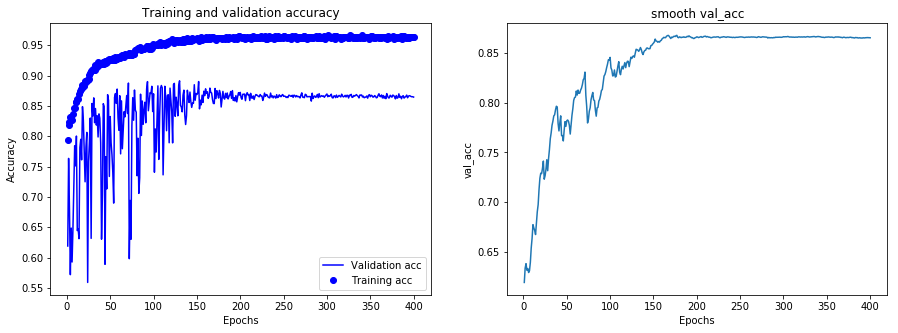

Highest val accuracy: x= 129, y= 0.8912977005870841


<Figure size 432x288 with 0 Axes>

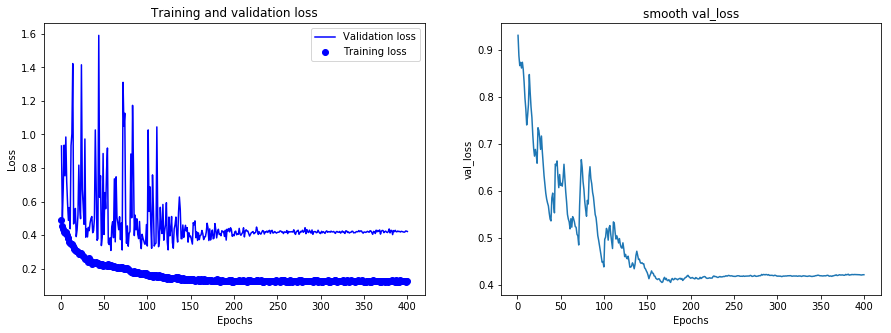

Lowest val loss: x= 57, y= 0.3091425260569018
26065.921550273895


In [15]:
plot_graphs(historyP4_DenseNet_48)
print(timeP4_DenseNet_48)

In [16]:
P4_DenseNet_48.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.815418205149253, 0.7874877690802349]

<Figure size 432x288 with 0 Axes>

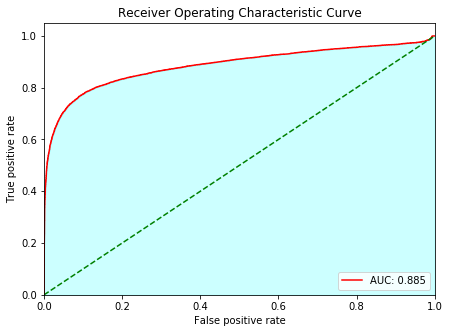

In [17]:
evaluate_auc(P4_DenseNet_48,test_generator)

In [49]:
P4_DenseNet_48.load_weights("model_saves/PCAM/PCAM_Dense/P4_DenseNet_48BestWeights58epochs.hdf5")

In [57]:
P4_DenseNet_48.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3052067637093613, 0.8798923679060665]

<Figure size 432x288 with 0 Axes>

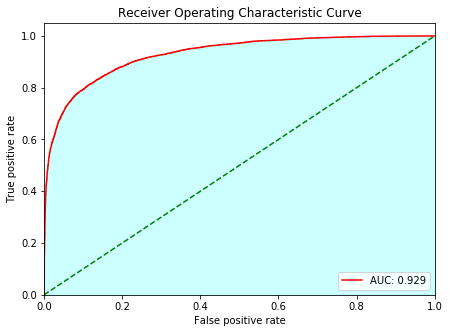

In [54]:
evaluate_auc(P4_DenseNet_48,test_generator)

### P4M-24

In [11]:
initial_filters = 6
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="Adam",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [132]:
P4M_DenseNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_462 (GConv2D)          (None, 94, 94, 48)   162         input_41[0][0]                   
__________________________________________________________________________________________________
g_batch_norm_460 (GBatchNorm)   (None, 94, 94, 48)   48          g_conv2d_462[0][0]               
__________________________________________________________________________________________________
activation_535 (Activation)     (None, 94, 94, 48)   0           g_batch_norm_460[0][0]           
__________________________________________________________________________________________________
g_conv2d_4

In [133]:
%%notify

totalepochs=600 

historyP4M_DenseNet = fit_model_to_directory_generator(P4M_DenseNet,train_generator,validation_generator,
                                           callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet = np.sum(time_check.epoch_times)
P4M_DenseNet.save_weights("model_saves/PCAM/PCAM_DENSE/replication_attempts/P4M_DenseNetFinal.h5")

Epoch 1/600
312/312 [==============================] - 79s 253ms/step - loss: 0.4824 - acc: 0.7834 - val_loss: 0.7380 - val_acc: 0.6910
Epoch 2/600
312/312 [==============================] - 73s 235ms/step - loss: 0.4133 - acc: 0.8173 - val_loss: 0.6462 - val_acc: 0.7699
Epoch 3/600
312/312 [==============================] - 76s 244ms/step - loss: 0.3612 - acc: 0.8462 - val_loss: 0.4640 - val_acc: 0.8077
Epoch 4/600
312/312 [==============================] - 70s 223ms/step - loss: 0.3296 - acc: 0.8643 - val_loss: 1.3670 - val_acc: 0.5272
Epoch 5/600
312/312 [==============================] - 68s 219ms/step - loss: 0.3027 - acc: 0.8801 - val_loss: 0.4244 - val_acc: 0.8239
Epoch 6/600
312/312 [==============================] - 69s 222ms/step - loss: 0.2900 - acc: 0.8864 - val_loss: 0.9826 - val_acc: 0.7200
Epoch 7/600
312/312 [==============================] - 71s 228ms/step - loss: 0.2737 - acc: 0.8943 - val_loss: 1.6267 - val_acc: 0.5082
Epoch 8/600
312/312 [===========================

312/312 [==============================] - 76s 243ms/step - loss: 0.1564 - acc: 0.9511 - val_loss: 0.2583 - val_acc: 0.9029
Epoch 120/600
312/312 [==============================] - 75s 242ms/step - loss: 0.1492 - acc: 0.9526 - val_loss: 0.3095 - val_acc: 0.8944
Epoch 121/600
312/312 [==============================] - 76s 244ms/step - loss: 0.1520 - acc: 0.9518 - val_loss: 0.2763 - val_acc: 0.8959
Epoch 122/600
312/312 [==============================] - 74s 237ms/step - loss: 0.1467 - acc: 0.9548 - val_loss: 0.3942 - val_acc: 0.8745
Epoch 123/600
312/312 [==============================] - 76s 245ms/step - loss: 0.1489 - acc: 0.9526 - val_loss: 0.3419 - val_acc: 0.8789
Epoch 124/600
312/312 [==============================] - 74s 237ms/step - loss: 0.1511 - acc: 0.9519 - val_loss: 0.3855 - val_acc: 0.8721
Epoch 125/600
312/312 [==============================] - 74s 239ms/step - loss: 0.1474 - acc: 0.9533 - val_loss: 0.3709 - val_acc: 0.8730
Epoch 126/600
312/312 [=========================

Epoch 235/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1337 - acc: 0.9586 - val_loss: 0.3099 - val_acc: 0.8954
Epoch 236/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1345 - acc: 0.9592 - val_loss: 0.3120 - val_acc: 0.8960
Epoch 237/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1355 - acc: 0.9572 - val_loss: 0.3138 - val_acc: 0.8951
Epoch 238/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1323 - acc: 0.9590 - val_loss: 0.3271 - val_acc: 0.8921
Epoch 239/600
312/312 [==============================] - 70s 224ms/step - loss: 0.1249 - acc: 0.9620 - val_loss: 0.3208 - val_acc: 0.8935
Learn rate updated from 7.812500371073838e-06 to: 3.906250185536919e-06
Epoch 240/600
312/312 [==============================] - 69s 223ms/step - loss: 0.1282 - acc: 0.9597 - val_loss: 0.3175 - val_acc: 0.8937
Epoch 241/600
312/312 [==============================] - 70s 224ms/step - loss: 0.1313 - acc: 0.9604

Epoch 293/600
312/312 [==============================] - 70s 223ms/step - loss: 0.1296 - acc: 0.9589 - val_loss: 0.3206 - val_acc: 0.8939
Epoch 294/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1360 - acc: 0.9581 - val_loss: 0.3229 - val_acc: 0.8933
Epoch 295/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1289 - acc: 0.9611 - val_loss: 0.3182 - val_acc: 0.8937
Epoch 296/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1317 - acc: 0.9605 - val_loss: 0.3184 - val_acc: 0.8952
Epoch 297/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1299 - acc: 0.9609 - val_loss: 0.3283 - val_acc: 0.8921
Epoch 298/600
312/312 [==============================] - 70s 224ms/step - loss: 0.1302 - acc: 0.9598 - val_loss: 0.3183 - val_acc: 0.8947
Epoch 299/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1299 - acc: 0.9596 - val_loss: 0.3229 - val_acc: 0.8935
Learn rate updated from 9.76562546

Epoch 351/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1291 - acc: 0.9608 - val_loss: 0.3125 - val_acc: 0.8959
Epoch 352/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1290 - acc: 0.9607 - val_loss: 0.3204 - val_acc: 0.8929
Epoch 353/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1288 - acc: 0.9607 - val_loss: 0.3193 - val_acc: 0.8949
Epoch 354/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1284 - acc: 0.9619 - val_loss: 0.3243 - val_acc: 0.8926
Epoch 355/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1302 - acc: 0.9605 - val_loss: 0.3107 - val_acc: 0.8966
Epoch 356/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1300 - acc: 0.9593 - val_loss: 0.3197 - val_acc: 0.8932
Epoch 357/600
312/312 [==============================] - 70s 225ms/step - loss: 0.1312 - acc: 0.9610 - val_loss: 0.3225 - val_acc: 0.8935
Epoch 358/600
312/312 [===========

Epoch 409/600
312/312 [==============================] - 70s 224ms/step - loss: 0.1268 - acc: 0.9603 - val_loss: 0.3243 - val_acc: 0.8939
Epoch 410/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1345 - acc: 0.9596 - val_loss: 0.3273 - val_acc: 0.8915
Epoch 411/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1293 - acc: 0.9604 - val_loss: 0.3179 - val_acc: 0.8929
Epoch 412/600
312/312 [==============================] - 69s 220ms/step - loss: 0.1338 - acc: 0.9588 - val_loss: 0.3139 - val_acc: 0.8964
Epoch 413/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1311 - acc: 0.9606 - val_loss: 0.3200 - val_acc: 0.8933
Epoch 414/600
312/312 [==============================] - 70s 223ms/step - loss: 0.1311 - acc: 0.9602 - val_loss: 0.3197 - val_acc: 0.8933
Epoch 415/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1293 - acc: 0.9603 - val_loss: 0.3239 - val_acc: 0.8937
Epoch 416/600
312/312 [===========

Epoch 467/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1356 - acc: 0.9590 - val_loss: 0.3256 - val_acc: 0.8922
Epoch 468/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1372 - acc: 0.9562 - val_loss: 0.3153 - val_acc: 0.8951
Epoch 469/600
312/312 [==============================] - 69s 220ms/step - loss: 0.1277 - acc: 0.9604 - val_loss: 0.3219 - val_acc: 0.8943
Epoch 470/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1290 - acc: 0.9608 - val_loss: 0.3205 - val_acc: 0.8923
Epoch 471/600
312/312 [==============================] - 69s 220ms/step - loss: 0.1291 - acc: 0.9602 - val_loss: 0.3210 - val_acc: 0.8955
Epoch 472/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1368 - acc: 0.9576 - val_loss: 0.3186 - val_acc: 0.8936
Epoch 473/600
312/312 [==============================] - 70s 223ms/step - loss: 0.1257 - acc: 0.9618 - val_loss: 0.3192 - val_acc: 0.8948
Epoch 474/600
312/312 [===========

Epoch 525/600
312/312 [==============================] - 70s 223ms/step - loss: 0.1348 - acc: 0.9588 - val_loss: 0.3184 - val_acc: 0.8949
Epoch 526/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1340 - acc: 0.9580 - val_loss: 0.3166 - val_acc: 0.8943
Epoch 527/600
312/312 [==============================] - 69s 223ms/step - loss: 0.1355 - acc: 0.9572 - val_loss: 0.3235 - val_acc: 0.8936
Epoch 528/600
312/312 [==============================] - 69s 220ms/step - loss: 0.1341 - acc: 0.9581 - val_loss: 0.3183 - val_acc: 0.8946
Epoch 529/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1307 - acc: 0.9608 - val_loss: 0.3200 - val_acc: 0.8926
Epoch 530/600
312/312 [==============================] - 69s 220ms/step - loss: 0.1326 - acc: 0.9605 - val_loss: 0.3233 - val_acc: 0.8937
Epoch 531/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1355 - acc: 0.9582 - val_loss: 0.3225 - val_acc: 0.8928
Epoch 532/600
312/312 [===========

Epoch 583/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1309 - acc: 0.9609 - val_loss: 0.3239 - val_acc: 0.8937
Epoch 584/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1331 - acc: 0.9592 - val_loss: 0.3172 - val_acc: 0.8941
Epoch 585/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1289 - acc: 0.9610 - val_loss: 0.3188 - val_acc: 0.8940
Epoch 586/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1282 - acc: 0.9605 - val_loss: 0.3249 - val_acc: 0.8933
Epoch 587/600
312/312 [==============================] - 69s 222ms/step - loss: 0.1288 - acc: 0.9608 - val_loss: 0.3183 - val_acc: 0.8938
Epoch 588/600
312/312 [==============================] - 69s 221ms/step - loss: 0.1339 - acc: 0.9582 - val_loss: 0.3200 - val_acc: 0.8945
Epoch 589/600
312/312 [==============================] - 69s 220ms/step - loss: 0.1304 - acc: 0.9601 - val_loss: 0.3220 - val_acc: 0.8929
Epoch 590/600
312/312 [===========

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

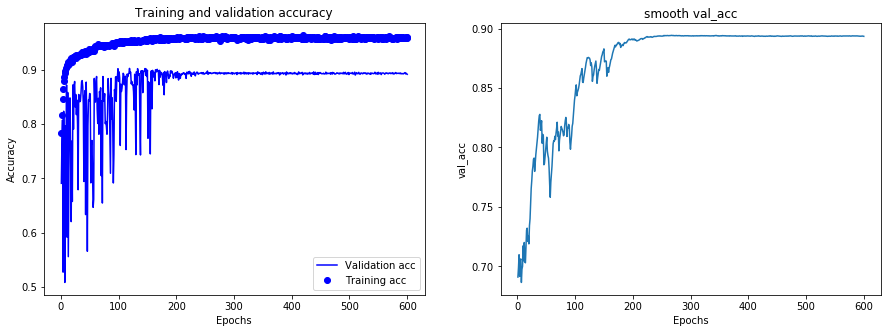

Highest val accuracy: x= 118, y= 0.9029170743639922


<Figure size 432x288 with 0 Axes>

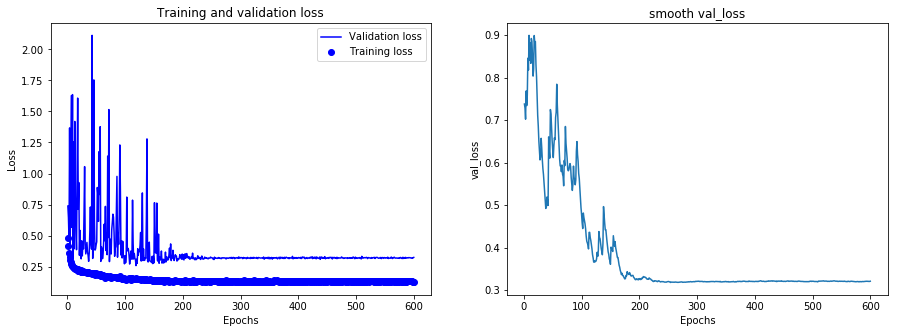

Lowest val loss: x= 118, y= 0.2582645977896487
42127.5870950222


In [141]:
plot_graphs(historyP4M_DenseNet)
print(timeP4M_DenseNet)

In [135]:
P4M_DenseNet.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3632966212476303, 0.8771098336594912]

In [12]:
P4M_DenseNet.load_weights("model_saves/PCAM/PCAM_Dense/replication_attempts/P4M_DenseNetBestWeights117epochs.hdf5")

In [140]:
P4M_DenseNet.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.31028233561847074, 0.8831641389432485]

<Figure size 432x288 with 0 Axes>

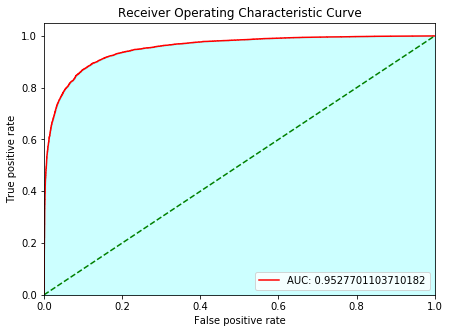

In [31]:
evaluate_auc(P4M_DenseNet,test_generator)

### P4M-64

In [10]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_64_Replication = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="Adam",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [11]:
P4M_DenseNet_64_Replication.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [11]:
%%notify

totalepochs=400

historyP4M_DenseNet_64_Replication = fit_model_to_directory_generator(P4M_DenseNet_64_Replication,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_64_Replication = np.sum(time_check.epoch_times)
P4M_DenseNet_64_Replication.save_weights("model_saves/PCAM/P4M_DenseNet_64_ReplicationFinal.h5")
save_history(historyP4M_DenseNet_64_Replication,"historyP4M_DenseNet_64_Replication")

<Figure size 432x288 with 0 Axes>

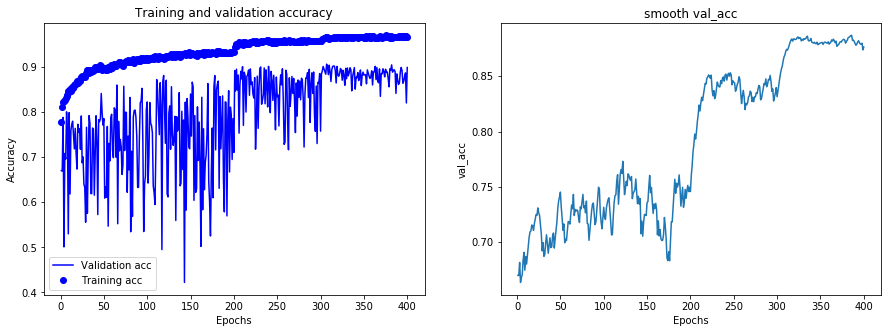

Highest val accuracy: x= 306, y= 0.9061888454011742


<Figure size 432x288 with 0 Axes>

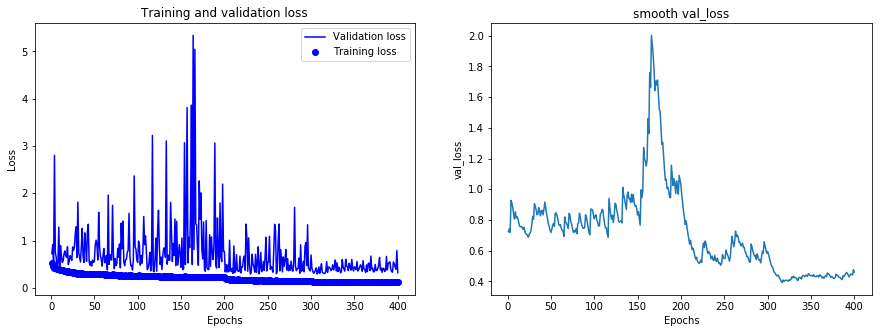

Lowest val loss: x= 229, y= 0.2913148059362068
40558.4400935173


In [12]:
plot_graphs(historyP4M_DenseNet_64_Replication)
print(timeP4M_DenseNet_64_Replication)

In [10]:
P4M_DenseNet_64_Replication.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.38762653155394494, 0.8752446183953033]

<Figure size 432x288 with 0 Axes>

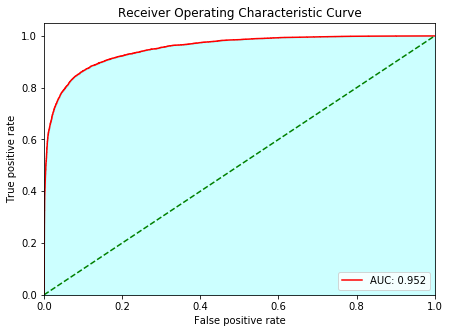

In [11]:
evaluate_auc(P4M_DenseNet_64_Replication,test_generator)

In [13]:
P4M_DenseNet_64_Replication.load_weights("model_saves/PCAM/PCAM_Dense/P4M_DenseNet_64_ReplicationBestWeights230epochs.hdf5")

In [18]:
P4M_DenseNet_64_Replication.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3337582707725859, 0.8899522994129159]

<Figure size 432x288 with 0 Axes>

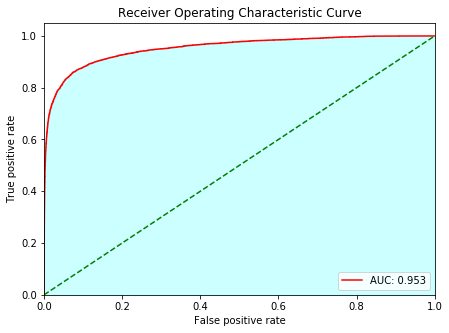

In [15]:
evaluate_auc(P4M_DenseNet_64_Replication,test_generator)